In [147]:
import re
import random
import pandas as pd
import hashlib

In [148]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [149]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
PEP 8,255.900717,85.300239,106.907528,3
Python,413.950072,8.807448,16.904850,47
Todd Ideas,963.065732,64.204382,154.157879,15
SharePoint,1674.146596,139.512216,578.639141,12
Audit Report Tracker (Sharepoint List),1808.048841,139.080680,366.727042,13
Debugging in VS Code,1963.578311,98.178916,261.052277,20
Azure Functions + Visual Studio,1964.460635,140.318617,481.986296,14
Terraform,2087.976051,83.519042,252.575345,25
IW Migration,2145.186245,153.227589,466.499780,14
Open Source/GitHub,2305.058554,144.066160,369.332798,16


# Histogram

81382.71


<Axes: >

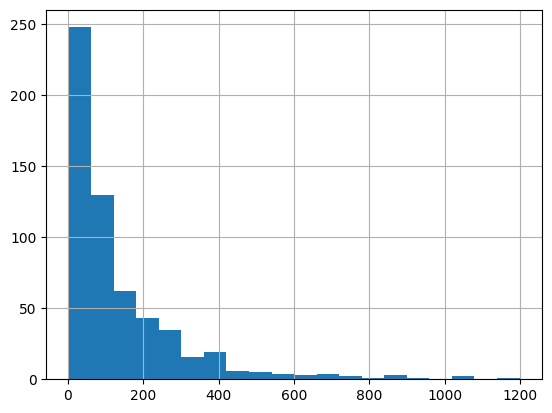

In [150]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [151]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [152]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [153]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [154]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [155]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [156]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [157]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [158]:
# n=10
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [159]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [160]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 585


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
113,Home Network Project,Front: What is TLS Termination and why is it u...,5297051eea9892af904815d3794faf15,-1198.906245,291.703848,-1198.906245,5542.373112,0.996185,0,0
114,Home Network Project,Front: Explain the difference between a Docker...,cae03ba26ac3afa5df9d5bb453b94dfd,-795.326212,291.703848,-1198.906245,5542.373112,0.996185,1,0
115,Home Network Project,What is the command to update and upgrade pack...,d0a754737eef42e651e9fff08f6a6292,-525.319246,291.703848,-1198.906245,5542.373112,0.996185,2,0
153,Azure Functions + PP365,Azure SDK for Python\nA collection of librarie...,80100a754471176d4959736d67f857f0,-1056.101919,209.154630,-1056.101919,5228.865755,0.775670,0,0
154,Azure Functions + PP365,Managed Identity Credential Acquisition\nThe p...,ce72b3d8456df269fc6040c655b72f2a,-680.468950,209.154630,-1056.101919,5228.865755,0.775670,1,0
155,Azure Functions + PP365,Environment Variables\nVariables set in the op...,06639ebf4c2d551971c41702ef6dfed2,-417.399361,209.154630,-1056.101919,5228.865755,0.775670,2,0
203,Logging in Python,Q: What does the exc_info parameter do in logg...,99985def14861364c32ddb3b87ea135b,-1032.039073,145.446747,-1032.039073,8726.804848,0.366186,0,0
204,Logging in Python,Q: What is the primary purpose of TimedRotatin...,faa326e87e35a9c530e145d8221882e1,-955.506192,145.446747,-1032.039073,8726.804848,0.366186,1,0
205,Logging in Python,Q: In TimedRotatingFileHandler from the loggin...,d53f8f76d58dd27e3ded74f30a190cb4,-684.090813,145.446747,-1032.039073,8726.804848,0.366186,2,0
33,Email Auth and Security,Identifier Alignment\n\nEnsuring that the doma...,74a89604ca7b2e38b605e5efbb01fe47,-897.347883,180.989785,-897.347883,2352.867210,0.596759,0,0


## Card Count

In [161]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [162]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [163]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
113,Home Network Project,Front: What is TLS Termination and why is it u...,5297051eea9892af904815d3794faf15,-1198.906245,291.703848,-1198.906245,5542.373112,0.996185,0,0
114,Home Network Project,Front: Explain the difference between a Docker...,cae03ba26ac3afa5df9d5bb453b94dfd,-795.326212,291.703848,-1198.906245,5542.373112,0.996185,1,0
115,Home Network Project,What is the command to update and upgrade pack...,d0a754737eef42e651e9fff08f6a6292,-525.319246,291.703848,-1198.906245,5542.373112,0.996185,2,0
153,Azure Functions + PP365,Azure SDK for Python\nA collection of librarie...,80100a754471176d4959736d67f857f0,-1056.101919,209.154630,-1056.101919,5228.865755,0.775670,0,0
154,Azure Functions + PP365,Managed Identity Credential Acquisition\nThe p...,ce72b3d8456df269fc6040c655b72f2a,-680.468950,209.154630,-1056.101919,5228.865755,0.775670,1,0
155,Azure Functions + PP365,Environment Variables\nVariables set in the op...,06639ebf4c2d551971c41702ef6dfed2,-417.399361,209.154630,-1056.101919,5228.865755,0.775670,2,0
203,Logging in Python,Q: What does the exc_info parameter do in logg...,99985def14861364c32ddb3b87ea135b,-1032.039073,145.446747,-1032.039073,8726.804848,0.366186,0,0
204,Logging in Python,Q: What is the primary purpose of TimedRotatin...,faa326e87e35a9c530e145d8221882e1,-955.506192,145.446747,-1032.039073,8726.804848,0.366186,1,0
205,Logging in Python,Q: In TimedRotatingFileHandler from the loggin...,d53f8f76d58dd27e3ded74f30a190cb4,-684.090813,145.446747,-1032.039073,8726.804848,0.366186,2,0
33,Email Auth and Security,Identifier Alignment\n\nEnsuring that the doma...,74a89604ca7b2e38b605e5efbb01fe47,-897.347883,180.989785,-897.347883,2352.867210,0.596759,0,0


In [164]:
existing_cards['age'].mean()

-139.11574299379853